# 한번 예시 해보기

In [63]:
from tensorflow.keras.datasets import fashion_mnist
import numpy as np
import tensorflow.keras as keras
from matplotlib import pyplot as plt
from tensorflow.keras.layers import Input,Dense,Flatten,Dropout,Reshape,Conv2D,MaxPooling2D,UpSampling2D,Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import load_model
%matplotlib inline

In [253]:
#load fashion_mnist dataset from keras 
(x_train_combined,y_train_combined), (x_test_combined,y_test_combined) = fashion_mnist.load_data()

In [254]:
print('Training data shape : ', x_train_combined.shape, y_train_combined.shape)
print('Testing data shape : ', x_test_combined.shape, y_test_combined.shape)

Training data shape :  (60000, 28, 28) (60000,)
Testing data shape :  (10000, 28, 28) (10000,)


Text(0.5, 1.0, 'Ground Truth : 9')

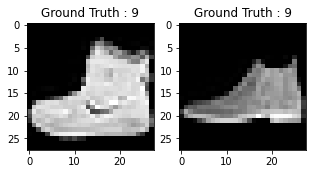

In [255]:
plt.figure(figsize=[5,5])

# Display the first image in training data
plt.subplot(121)
plt.imshow(x_train_combined[0,:,:], cmap='gray')
plt.title("Ground Truth : {}".format(y_train_combined[0]))

# Display the first image in testing data
plt.subplot(122)
plt.imshow(x_test_combined[0,:,:], cmap='gray')
plt.title("Ground Truth : {}".format(y_test_combined[0]))

In [256]:
print(x_train_combined.shape)
print(x_test_combined.shape)

(60000, 28, 28)
(10000, 28, 28)


In [257]:
def filter(xs, ys, lbls):
    idxs = [i for (i, y) in enumerate(ys) if y in lbls]
    xsprime = np.zeros((len(idxs), xs.shape[1], xs.shape[2]))
    for (i, j) in enumerate(idxs):
        xsprime[i] = xs[j]
    ymap = {}
    for (yprime, y) in enumerate(lbls):
        ymap[y] = yprime
    ysprime = np.array([ymap[y] for y in ys[idxs]])
    return xsprime, ysprime

fm1lbls = [0, 1, 4, 5, 8]
x_train_fm1, y_train_fm1 = filter(x_train_combined, y_train_combined, fm1lbls)
x_test_fm1, y_test_fm1 = filter(x_test_combined, y_test_combined, fm1lbls)

fm1classes  = fm1lbls
fm1nClasses = len(fm1classes)

fm2lbls = [2, 3, 6, 7, 9]
x_train_fm2, y_train_fm2 = filter(x_train_combined, y_train_combined, fm2lbls)
x_test_fm2, y_test_fm2 = filter(x_test_combined, y_test_combined, fm2lbls)

fm2classes  = fm2lbls
fm2nClasses = len(fm2classes)

In [258]:
print(x_train_fm2.shape)
print(x_test_fm2.shape)

(30000, 28, 28)
(5000, 28, 28)


In [259]:
np.concatenate((x_train_fm2, x_test_fm2), axis=0).shape

(35000, 28, 28)

In [260]:
# Convert data type from int8 to float32
x_train_fm1 = x_train_fm1.astype('float32')
x_test_fm1 = x_test_fm1.astype('float32')

x_train_fm2 = x_train_fm2.astype('float32')
x_test_fm2 = x_test_fm2.astype('float32')

# Normalize the data: rescale the pixel values in range 0 - 1 inclusive for training purposes
x_train_fm1 = x_train_fm1 / 255.
x_test_fm1 = x_test_fm1 / 255.

x_train_fm2 = x_train_fm2 / 255.
x_test_fm2 = x_test_fm2 / 255.


In [261]:
from sklearn.model_selection import train_test_split
x_train_fm1,x_valid_fm1,x_train_ground_fm1,x_valid_ground_fm1 = train_test_split(x_train_fm1,
                                                             x_train_fm1, 
                                                             test_size=0.2, 
                                                             random_state=13)

x_train_fm2,x_valid_fm2,x_train_ground_fm2,x_valid_ground_fm2 = train_test_split(x_train_fm2,
                                                             x_train_fm2, 
                                                             test_size=0.2, 
                                                             random_state=13)

In [262]:
x_train_fm1 = x_train_fm1.reshape(-1, 28,28, 1)
x_valid_fm1 = x_valid_fm1.reshape(-1, 28,28, 1)

x_train_ground_fm1 = x_train_ground_fm1.reshape(-1, 28,28, 1)
x_valid_ground_fm1 = x_valid_ground_fm1.reshape(-1, 28,28, 1)

x_test_fm1 = x_test_fm1.reshape(-1, 28,28, 1)

x_train_fm2 = x_train_fm2.reshape(-1, 28,28, 1)
x_valid_fm2 = x_valid_fm2.reshape(-1, 28,28, 1)

x_train_ground_fm2 = x_train_ground_fm2.reshape(-1, 28,28, 1)
x_valid_ground_fm2 = x_valid_ground_fm2.reshape(-1, 28,28, 1)

x_test_fm1 = x_test_fm1.reshape(-1, 28,28, 1)
x_test_fm2 = x_test_fm2.reshape(-1, 28,28, 1)

In [263]:
# fm2_all_combined = x_train_fm2 + x_valid_fm2 + x_test_fm2
fm2_all_combined = np.concatenate((x_train_fm2, x_valid_fm2), axis =0)
fm2_all_combined = np.concatenate((fm2_all_combined, x_test_fm2), axis =0)
fm2_all_combined.shape

(35000, 28, 28, 1)

In [264]:
x_train_total = np.concatenate((fm2_all_combined, x_train_fm1), axis = 0)

In [265]:
x_train_total,x_valid_total,x_train_total_ground,x_valid_total_ground = train_test_split(x_train_total,
                                                             x_train_total, 
                                                             test_size=0.2, 
                                                             random_state=13)

In [266]:
batch_size = 64
epochs = 50
input_img = Input(shape = (28, 28, 1))
learning_rate = 1e-3
num_classes = 5

In [267]:
# Callback Functions
# early_stopping_monitor = EarlyStopping(monitor = 'val_loss', patience=5, verbose=1)
early_stopping_monitor = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min', restore_best_weights=True)

In [268]:
def encoder(input_img):
    #encoder
    #input = 28 x 28 x 1 (wide and thin)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img) #28 x 28 x 32
    conv1 = BatchNormalization()(conv1)
#     conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
#     conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1) #14 x 14 x 32
    dropout1 = Dropout(0.2)(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(dropout1) #14 x 14 x 64
    conv2 = BatchNormalization()(conv2)
#     conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
#     conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2) #7 x 7 x 64
    dropout2 = Dropout(0.2)(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(dropout2) #7 x 7 x 128 (small and thick)
    conv3 = BatchNormalization()(conv3)
#     conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
#     conv3 = BatchNormalization()(conv3)
    dropout3 = Dropout(0.2)(conv3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(dropout3) #7 x 7 x 256 (small and thick)
    conv4 = BatchNormalization()(conv4)
#     conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
#     conv4 = BatchNormalization()(conv4)
    return conv4

def decoder(conv4):    
    #decoder
    conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv4) #7 x 7 x 128
#     conv5 = BatchNormalization()(conv5)
#     conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv5)
    dropout4 = Dropout(0.2)(conv5)
    conv5 = BatchNormalization()(conv5)
    conv6 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv5) #7 x 7 x 64
#     conv6 = BatchNormalization()(conv6)
#     conv6 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv6)
    conv6 = BatchNormalization()(conv6)
    up1 = UpSampling2D((2,2))(conv6) #14 x 14 x 64
    dropout5 = Dropout(0.2)(up1)
    conv7 = Conv2D(32, (3, 3), activation='relu', padding='same')(up1) # 14 x 14 x 32
    conv7 = BatchNormalization()(conv7)
#     conv7 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv7)
#     conv7 = BatchNormalization()(conv7)
    up2 = UpSampling2D((2,2))(conv7) # 28 x 28 x 32
    dropout6 = Dropout(0.2)(up2)
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(dropout6) # 28 x 28 x 1
    return decoded


In [269]:
def encoder(input_img):
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img) #28 x 28 x 32
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1) #14 x 14 x 32
    dropout1 = Dropout(0.2)(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(dropout1) #14 x 14 x 64
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2) #7 x 7 x 64
    dropout2 = Dropout(0.2)(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(dropout2) #7 x 7 x 128 (small and thick)
    conv3 = BatchNormalization()(conv3)
    dropout3 = Dropout(0.2)(conv3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(dropout3) #7 x 7 x 256 (small and thick)
    encoded = BatchNormalization()(conv4)
    return encoded

def decoder(encoded):    
    conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(encoded) #7 x 7 x 128
    dropout4 = Dropout(0.2)(conv5)
    conv5 = BatchNormalization()(conv5)
    conv6 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv5) #7 x 7 x 64
    conv6 = BatchNormalization()(conv6)
    up1 = UpSampling2D((2,2))(conv6) #14 x 14 x 64
    dropout5 = Dropout(0.2)(up1)
    conv7 = Conv2D(32, (3, 3), activation='relu', padding='same')(up1) # 14 x 14 x 32
    conv7 = BatchNormalization()(conv7)
    up2 = UpSampling2D((2,2))(conv7) # 28 x 28 x 32
    dropout6 = Dropout(0.2)(up2)
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(dropout6) # 28 x 28 x 1
    return decoded

In [270]:
autoencoder = Model(input_img, decoder(encoder(input_img)))
autoencoder.compile(loss='mean_squared_error', optimizer = Adam(), metrics=['accuracy'])
autoencoder.summary()

Model: "model_91"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_755 (Conv2D)          (None, 28, 28, 32)        320       
_________________________________________________________________
batch_normalization_752 (Bat (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_187 (MaxPoolin (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_377 (Dropout)        (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_756 (Conv2D)          (None, 14, 14, 64)        18496     
_________________________________________________________________
batch_normalization_753 (Bat (None, 14, 14, 64)        256

In [271]:
autoencoder_train = autoencoder.fit(x_train_total, x_train_total_ground, batch_size=batch_size,epochs=epochs,verbose=1, shuffle=True, callbacks=[early_stopping_monitor], validation_data=(x_valid_total, x_valid_total_ground))

Train on 47200 samples, validate on 11800 samples
Epoch 1/50
20352/47200 [===========>..................] - ETA: 3s - loss: 0.0218 - accuracy: 0.5051WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


KeyboardInterrupt: 

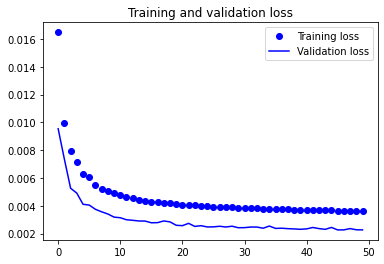

In [246]:
loss = autoencoder_train.history['loss']
val_loss = autoencoder_train.history['val_loss']
epochs = range(len(loss))
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [247]:
pred_fm1 = autoencoder.predict(x_test_fm1)
print(pred_fm1.shape)

(5000, 28, 28, 1)


Test Images


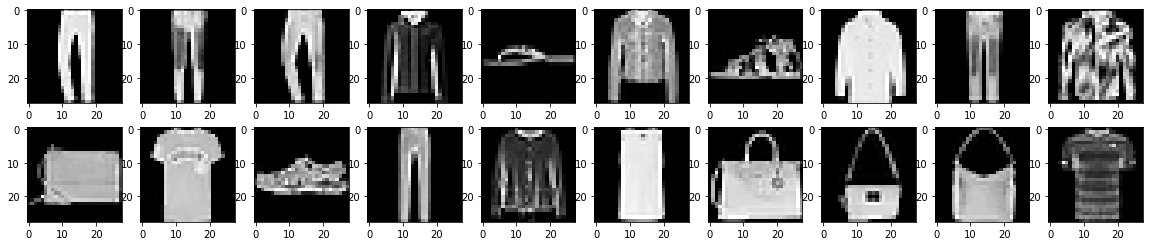

Reconstruction of Test Images


<Figure size 1440x288 with 0 Axes>

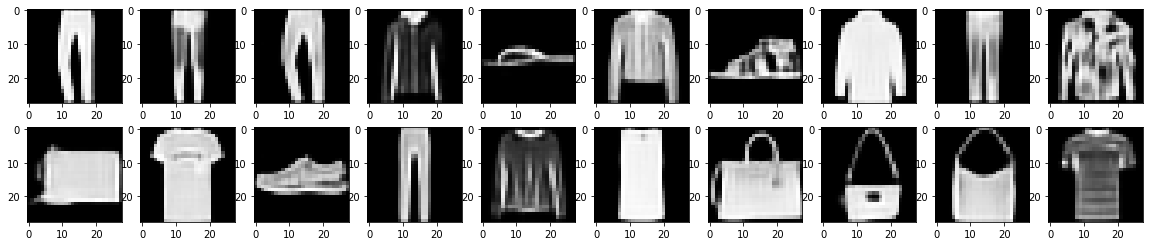

In [248]:
plt.figure(figsize=(20, 4))
print("Test Images")
for i in range(20):
    plt.subplot(2, 10, i+1)
    plt.imshow(x_test_fm1[i, ..., 0], cmap='gray')
plt.show()    
plt.figure(figsize=(20, 4))

plt.figure(figsize=(20, 4))
print("Reconstruction of Test Images")
for i in range(20):
    plt.subplot(2, 10, i+1)
    plt.imshow(pred_fm1[i, ..., 0], cmap='gray')  
plt.show()

In [249]:
autoencoder.save_weights('autoencoder.h5')

# =====================

# Question 3

In [149]:
#load fashion_mnist dataset from keras 
(x_train_combined,y_train_combined), (x_test_combined,y_test_combined) = fashion_mnist.load_data()

In [150]:
print('Training data shape : ', x_train_combined.shape, y_train_combined.shape)
print('Testing data shape : ', x_test_combined.shape, y_test_combined.shape)

Training data shape :  (60000, 28, 28) (60000,)
Testing data shape :  (10000, 28, 28) (10000,)


In [151]:
def filter(xs, ys, lbls):
    idxs = [i for (i, y) in enumerate(ys) if y in lbls]
    xsprime = np.zeros((len(idxs), xs.shape[1], xs.shape[2]))
    for (i, j) in enumerate(idxs):
        xsprime[i] = xs[j]
    ymap = {}
    for (yprime, y) in enumerate(lbls):
        ymap[y] = yprime
    ysprime = np.array([ymap[y] for y in ys[idxs]])
    return xsprime, ysprime

fm1lbls = [0, 1, 4, 5, 8]
x_train_fm1, y_train_fm1 = filter(x_train_combined, y_train_combined, fm1lbls)
x_test_fm1, y_test_fm1 = filter(x_test_combined, y_test_combined, fm1lbls)

fm1classes  = fm1lbls
fm1nClasses = len(fm1classes)


In [152]:
x_train_fm1 = x_train_fm1.reshape(-1, 28,28, 1)
x_test_fm1 = x_test_fm1.reshape(-1, 28,28, 1)

In [153]:
# Convert data type from int8 to float32
x_train_fm1 = x_train_fm1.astype('float32')
x_test_fm1 = x_test_fm1.astype('float32')

# Normalize the data: rescale the pixel values in range 0 - 1 inclusive for training purposes
x_train_fm1 = x_train_fm1 / 255.
x_test_fm1 = x_test_fm1 / 255.



In [154]:
y_train_one_hot_fm1 = to_categorical(y_train_fm1)
y_test_one_hot_fm1 = to_categorical(y_test_fm1)
print(y_train_one_hot_fm1)

[[1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 ...
 [0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]]


In [155]:
from sklearn.model_selection import train_test_split
x_train_fm1,x_valid_fm1,x_train_fm1_label,x_valid_fm1_label = train_test_split(x_train_fm1,
                                                             y_train_one_hot_fm1, 
                                                             test_size=0.2, 
                                                             random_state=13)


In [83]:
def fully_connected_layer(encoder):
    flatten = Flatten()(encoder)
    dense = Dense(128, activation='relu')(flatten)
    dense = Dropout(0.3)(dense)
    output = Dense(num_classes, activation='softmax')(dense)
    return output

In [84]:
encode = encoder(input_img)
full_model = Model(input_img,fully_connected_layer(encode))

In [85]:
# full_model.layers

In [86]:
for l1,l2 in zip(full_model.layers[:22],autoencoder.layers[0:22]):
    l1.set_weights(l2.get_weights())

In [87]:
len(full_model.layers)

26

In [88]:
len(autoencoder.layers)

38

In [89]:
# autoencoder.get_weights()[0][1]

In [90]:
# full_model.get_weights()[0][1]

In [91]:
for layer in full_model.layers[0:22]:
    layer.trainable = False

In [92]:
learning_rate = 1e-5

In [93]:
full_model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(lr=learning_rate),metrics=['accuracy'])

In [94]:
full_model.summary()

Model: "model_43"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_367 (Conv2D)          (None, 28, 28, 32)        320       
_________________________________________________________________
batch_normalization_366 (Bat (None, 28, 28, 32)        128       
_________________________________________________________________
conv2d_368 (Conv2D)          (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_367 (Bat (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_90 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_180 (Dropout)        (None, 14, 14, 32)        0  

In [90]:
print(x_train_fm1.shape)
print(x_train_fm1_label.shape)
print(x_valid_fm1.shape)
x_train_fm1_label

(24000, 28, 28, 1)
(24000, 5)
(6000, 28, 28, 1)


array([[1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.]], dtype=float32)

In [91]:
classify_train = full_model.fit(x_train_fm1, x_train_fm1_label, batch_size=64,epochs=50,verbose=1, shuffle=True, callbacks=[early_stopping_monitor], validation_data=(x_valid_fm1, x_valid_fm1_label))
# classify_train = full_model.fit(x_train_fm1, x_train_fm1_label, batch_size=64,epochs=20,verbose=1, shuffle=True, validation_data=(x_valid_fm1, x_valid_fm1_label))

Train on 24000 samples, validate on 6000 samples
Epoch 1/50
24000/24000 [==============================] - 2s 87us/sample - loss: 0.3606 - accuracy: 0.8819 - val_loss: 0.0897 - val_accuracy: 0.9753
Epoch 2/50
24000/24000 [==============================] - 1s 57us/sample - loss: 0.1080 - accuracy: 0.9684 - val_loss: 0.0662 - val_accuracy: 0.9800
Epoch 3/50
24000/24000 [==============================] - 1s 56us/sample - loss: 0.0785 - accuracy: 0.9758 - val_loss: 0.0568 - val_accuracy: 0.9838
Epoch 4/50
24000/24000 [==============================] - 1s 55us/sample - loss: 0.0613 - accuracy: 0.9823 - val_loss: 0.0520 - val_accuracy: 0.9848
Epoch 5/50
24000/24000 [==============================] - 1s 56us/sample - loss: 0.0509 - accuracy: 0.9843 - val_loss: 0.0507 - val_accuracy: 0.9848
Epoch 6/50
24000/24000 [==============================] - 1s 56us/sample - loss: 0.0420 - accuracy: 0.9874 - val_loss: 0.0469 - val_accuracy: 0.9858
Epoch 7/50
24000/24000 [==============================] -

In [45]:
full_model.save('autoencoder_classification.h5')

In [46]:
# for layer in full_model.layers[0:22]:
#     layer.trainable = True

In [47]:
# full_model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(lr=learning_rate),metrics=['accuracy'])

In [48]:
# classify_train = full_model.fit(x_train_fm1, x_train_fm1_label, batch_size=64,epochs=20,verbose=1,shuffle=True, callbacks=[early_stopping_monitor], validation_data=(x_valid_fm1, x_valid_fm1_label))
# classify_train = full_model.fit(x_train_fm1, x_train_fm1_label, batch_size=64,epochs=20,verbose=1,shuffle=True, validation_data=(x_valid_fm1, x_valid_fm1_label))

In [49]:
# full_model = load_model('pretrained_5percent.h5')

In [50]:
type(classify_train.history['loss'])

list

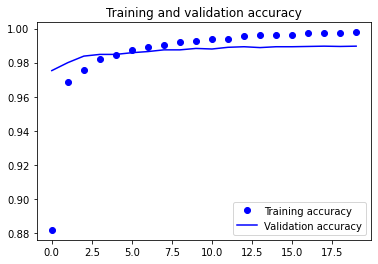

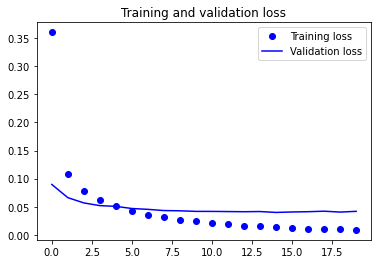

In [92]:
accuracy = classify_train.history['accuracy']
val_accuracy = classify_train.history['val_accuracy']
loss = classify_train.history['loss']
val_loss = classify_train.history['val_loss']
epochs = range(len(loss))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [52]:
test_eval = full_model.evaluate(x_test_fm1, y_test_one_hot_fm1, verbose=1)

5000/5000 [==============================] - 0s 61us/sample - loss: 0.0404 - accuracy: 0.9880


In [53]:
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

Test loss: 0.040382058008445895
Test accuracy: 0.988


In [54]:
predicted_classes = full_model.predict(x_test_fm1)

In [55]:
predicted_classes = np.argmax(np.round(predicted_classes),axis=1)

In [56]:
predicted_classes.shape, x_test_fm1.shape

((5000,), (5000, 28, 28, 1))

Found 4940 correct labels


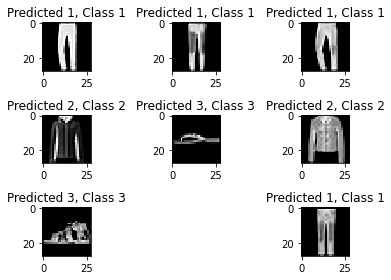

In [57]:
correct = np.where(predicted_classes==y_test_fm1)[0]
print("Found %d correct labels" % len(correct))
for i, correct in enumerate(correct[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(x_test_fm1[correct].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted_classes[correct], y_test_fm1[correct]))
    plt.tight_layout()

# Question  4

In [177]:
#load fashion_mnist dataset from keras 
(x_train_combined,y_train_combined), (x_test_combined,y_test_combined) = fashion_mnist.load_data()

In [178]:
print('Training data shape : ', x_train_combined.shape, y_train_combined.shape)
print('Testing data shape : ', x_test_combined.shape, y_test_combined.shape)

Training data shape :  (60000, 28, 28) (60000,)
Testing data shape :  (10000, 28, 28) (10000,)


In [179]:
def filter(xs, ys, lbls):
    idxs = [i for (i, y) in enumerate(ys) if y in lbls]
    xsprime = np.zeros((len(idxs), xs.shape[1], xs.shape[2]))
    for (i, j) in enumerate(idxs):
        xsprime[i] = xs[j]
    ymap = {}
    for (yprime, y) in enumerate(lbls):
        ymap[y] = yprime
    ysprime = np.array([ymap[y] for y in ys[idxs]])
    return xsprime, ysprime

fm1lbls = [0, 1, 4, 5, 8]
x_train_fm1, y_train_fm1 = filter(x_train_combined, y_train_combined, fm1lbls)
x_test_fm1, y_test_fm1 = filter(x_test_combined, y_test_combined, fm1lbls)

fm1classes  = fm1lbls
fm1nClasses = len(fm1classes)


In [180]:
x_train_fm1 = x_train_fm1.reshape(-1, 28,28, 1)
x_test_fm1 = x_test_fm1.reshape(-1, 28,28, 1)

In [181]:
# Convert data type from int8 to float32
x_train_fm1 = x_train_fm1.astype('float32')
x_test_fm1 = x_test_fm1.astype('float32')

# Normalize the data: rescale the pixel values in range 0 - 1 inclusive for training purposes
x_train_fm1 = x_train_fm1 / 255.
x_test_fm1 = x_test_fm1 / 255.

x_train_fm1.shape

(30000, 28, 28, 1)

In [182]:
y_train_one_hot_fm1 = to_categorical(y_train_fm1)
y_test_one_hot_fm1 = to_categorical(y_test_fm1)
print(y_train_one_hot_fm1)

[[1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 ...
 [0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]]


In [183]:
def fully_connected_layer(encoder):
    flatten = Flatten()(encoder)
    dense = Dense(128, activation='relu')(flatten)
    dense = Dropout(0.3)(dense)
    output = Dense(num_classes, activation='softmax')(dense)
    return output

In [111]:
pretrained_loss = []
pretrained_val_loss = []
random_init_loss = []
random_init_val_loss = []

# saves the number of epochs to reach the optimal value
pretrained_train_epoch = []
pretrained_val_epoch = []
random_init_train_epoch = []
random_init_val_epoch = []

In [112]:
from sklearn.model_selection import train_test_split
percentage = [0.95, 0.90, 0.85, 0.80, 0.75, 0.70, 0.65, 0.60, 0.55, 0.50, 0.45, 0.40, 0.35, 0.30, 0.25, 0.20, 0.15, 0.10, 0.05, 0]
for data_proportion in percentage:
    if data_proportion == 0:
        x_train_fm1_subset = x_train_fm1
        x_train_fm1_label_subset = y_train_one_hot_fm1
    else:
        x_train_fm1_subset,temp1,x_train_fm1_label_subset,temp2 = train_test_split(x_train_fm1,
                                                             y_train_one_hot_fm1, 
                                                             test_size=data_proportion, 
                                                             random_state=13)
        
    x_train_fm1_subset,x_valid_fm1_subset,x_train_fm1_label_subset,x_valid_fm1_label_subset = train_test_split(x_train_fm1_subset,
                                                             x_train_fm1_label_subset, 
                                                             test_size=0.2, 
                                                             random_state=13)
    
    #for pre-trained initialisation
    encode = encoder(input_img)
    classifer = Model(input_img,fully_connected_layer(encode))
    
    for l1,l2 in zip(classifer.layers[:22],autoencoder.layers[0:22]):
        l1.set_weights(l2.get_weights())
        
    for layer in classifer.layers[0:22]:
        layer.trainable = False
    classifer.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(lr=learning_rate),metrics=['accuracy'])
    classify_train = classifer.fit(x_train_fm1_subset, x_train_fm1_label_subset, batch_size=64,epochs=50,verbose=0, shuffle=True, callbacks=[early_stopping_monitor], validation_data=(x_valid_fm1_subset, x_valid_fm1_label_subset))
    
    classifer.save('models/pretrained_' + str(round((1 - data_proportion) * 100)) +'percent.h5')
    
    loss = classify_train.history['loss']
    val_loss = classify_train.history['val_loss']
    
    optimal_loss = min(loss)
    optimal_val_loss = min(val_loss)
    
    pretrained_loss.append(optimal_loss)
    pretrained_val_loss.append(optimal_val_loss)
    
    pretrained_train_epoch.append(loss.index(optimal_loss))
    pretrained_val_epoch.append(val_loss.index(optimal_val_loss))
    
    #for random initialisation
    encode = encoder(input_img)
    classifer = Model(input_img,fully_connected_layer(encode))
    
    for layer in classifer.layers[0:22]:
        layer.trainable = True
        
    classifer.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(lr=learning_rate),metrics=['accuracy'])
    classify_train = classifer.fit(x_train_fm1_subset, x_train_fm1_label_subset, batch_size=64,epochs=50,verbose=0, shuffle=True, validation_data=(x_valid_fm1_subset, x_valid_fm1_label_subset))
    
    classifer.save('models/random_init_' + str(round((1 - data_proportion) * 100)) +'percent.h5')
    
    loss = classify_train.history['loss']
    val_loss = classify_train.history['val_loss']
    
    optimal_loss = min(loss)
    optimal_val_loss = min(val_loss)
    
    random_init_loss.append(optimal_loss)
    random_init_val_loss.append(optimal_val_loss)
    
    random_init_train_epoch.append(loss.index(optimal_loss))
    random_init_val_epoch.append(val_loss.index(optimal_val_loss))

Restoring model weights from the end of the best epoch.
Epoch 00049: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00034: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00041: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00024: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00027: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00024: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00022: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00023: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00030: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00027: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00025: early s

In [113]:
print(len(pretrained_loss))
print(len(pretrained_val_loss))
print(len(random_init_loss))
print(len(random_init_val_loss))

20
20
20
20


In [116]:
pretrained_train_epoch

[44,
 31,
 39,
 23,
 26,
 22,
 21,
 22,
 30,
 28,
 26,
 24,
 18,
 20,
 19,
 24,
 20,
 27,
 22,
 18]

In [114]:
x_values = [round((1 - i) * 100) for i in percentage]
type(str(x_values[0]))

str

[5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100]


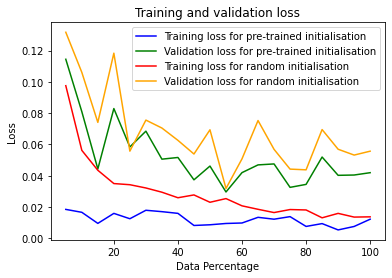

<Figure size 432x288 with 0 Axes>

In [226]:
# accuracy = classify_train.history['accuracy']
# val_accuracy = classify_train.history['val_accuracy']
# loss = classify_train.history['loss']
# val_loss = classify_train.history['val_loss']
x_values = [round((1 - i) * 100) for i in percentage]
print(x_values)
epochs = range(len(pretrained_loss))
plt.plot(x_values, pretrained_loss, 'b', label='Training loss for pre-trained initialisation')
plt.plot(x_values, pretrained_val_loss, 'b', color = 'green', label='Validation loss for pre-trained initialisation')
plt.plot(x_values, random_init_loss, 'b', color='red',label='Training loss for random initialisation')
plt.plot(x_values, random_init_val_loss, 'b', color='orange', label='Validation loss for random initialisation')
plt.title('Training and validation loss')
plt.xlabel("Data Percentage")
plt.ylabel("Loss")
plt.legend()
plt.figure()
plt.show()

[5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100]


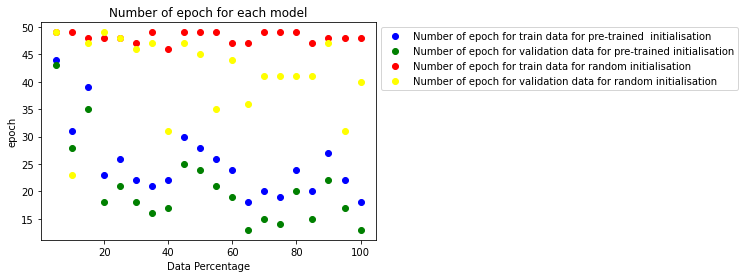

<Figure size 432x288 with 0 Axes>

In [227]:
x_values = [round((1 - i) * 100) for i in percentage]
print(x_values)
plt.plot(x_values, pretrained_train_epoch, 'bo', color='blue', label='Number of epoch for train data for pre-trained  initialisation')
plt.plot(x_values, pretrained_val_epoch, 'bo', color='green', label='Number of epoch for validation data for pre-trained initialisation')
plt.plot(x_values, random_init_train_epoch, 'bo', color='red',label='Number of epoch for train data for random initialisation')
plt.plot(x_values, random_init_val_epoch, 'bo', color='yellow', label='Number of epoch for validation data for random initialisation')
plt.title('Number of epoch for each model')
plt.xlabel("Data Percentage")
plt.ylabel("epoch")
plt.legend(bbox_to_anchor=(1.0,1.0))
plt.figure()
plt.show()

# Question 5

In [199]:
pretrained_optimal = min(pretrained_val_loss)
random_optimal = min(random_init_val_loss)
print(pretrained_optimal)
print(random_optimal)

0.029626259264169317
0.03186394603076306


In [200]:
optimal_percent_pretrained = pretrained_val_loss.index(pretrained_optimal)
optimal_percent_random = random_init_val_loss.index(random_optimal)

print(optimal_percent_pretrained)
print(optimal_percent_random)

10
10


In [201]:
x_values[optimal_percent_pretrained]

55

In [202]:
pretrained_model = load_model('models/pretrained_55percent.h5')

In [203]:
test_eval = pretrained_model.evaluate(x_test_fm1, y_test_one_hot_fm1, batch_size =64, verbose=1)

5000/5000 [==============================] - 0s 74us/sample - loss: 0.0424 - accuracy: 0.9866


In [204]:
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

Test loss: 0.04239443210916361
Test accuracy: 0.9866


# ====================================================

In [217]:
#load fashion_mnist dataset from keras 
(x_train_combined,y_train_combined), (x_test_combined,y_test_combined) = fashion_mnist.load_data()

In [218]:
print('Training data shape : ', x_train_combined.shape, y_train_combined.shape)
print('Testing data shape : ', x_test_combined.shape, y_test_combined.shape)

Training data shape :  (60000, 28, 28) (60000,)
Testing data shape :  (10000, 28, 28) (10000,)


In [219]:
def filter(xs, ys, lbls):
    idxs = [i for (i, y) in enumerate(ys) if y in lbls]
    xsprime = np.zeros((len(idxs), xs.shape[1], xs.shape[2]))
    for (i, j) in enumerate(idxs):
        xsprime[i] = xs[j]
    ymap = {}
    for (yprime, y) in enumerate(lbls):
        ymap[y] = yprime
    ysprime = np.array([ymap[y] for y in ys[idxs]])
    return xsprime, ysprime

fm1lbls = [0, 1, 4, 5, 8]
x_train_fm1, y_train_fm1 = filter(x_train_combined, y_train_combined, fm1lbls)
x_test_fm1, y_test_fm1 = filter(x_test_combined, y_test_combined, fm1lbls)

fm1classes  = fm1lbls
fm1nClasses = len(fm1classes)


In [220]:
x_train_fm1 = x_train_fm1.reshape(-1, 28,28, 1)
x_test_fm1 = x_test_fm1.reshape(-1, 28,28, 1)

In [221]:
# Convert data type from int8 to float32
x_train_fm1 = x_train_fm1.astype('float32')
x_test_fm1 = x_test_fm1.astype('float32')

# Normalize the data: rescale the pixel values in range 0 - 1 inclusive for training purposes
x_train_fm1 = x_train_fm1 / 255.
x_test_fm1 = x_test_fm1 / 255.

x_train_fm1.shape

(30000, 28, 28, 1)

In [222]:
y_train_one_hot_fm1 = to_categorical(y_train_fm1)
y_test_one_hot_fm1 = to_categorical(y_test_fm1)
print(y_train_one_hot_fm1)

[[1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 ...
 [0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]]


In [223]:
def fully_connected_layer(encoder):
    flatten = Flatten()(encoder)
    dense = Dense(128, activation='relu')(flatten)
    dense = Dropout(0.3)(dense)
    output = Dense(num_classes, activation='softmax')(dense)
    return output

In [192]:
x_train_fm1_subset,temp1,x_train_fm1_label_subset,temp2 = train_test_split(x_train_fm1,
                                                         y_train_one_hot_fm1, 
                                                         test_size=0.45, 
                                                         random_state=13)

x_train_fm1_subset,x_valid_fm1_subset,x_train_fm1_label_subset,x_valid_fm1_label_subset = train_test_split(x_train_fm1_subset,
                                                         x_train_fm1_label_subset, 
                                                         test_size=0.2, 
                                                         random_state=13)

#for pre-trained initialisation
encode = encoder(input_img)
classifer = Model(input_img,fully_connected_layer(encode))

for l1,l2 in zip(classifer.layers[:22],autoencoder.layers[0:22]):
    l1.set_weights(l2.get_weights())

for layer in classifer.layers[0:22]:
    layer.trainable = False
classifer.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(lr=learning_rate),metrics=['accuracy'])
classify_train = classifer.fit(x_train_fm1_subset, x_train_fm1_label_subset, batch_size=64,epochs=50,verbose=1, shuffle=True, callbacks=[early_stopping_monitor], validation_data=(x_valid_fm1_subset, x_valid_fm1_label_subset))




Train on 13200 samples, validate on 3300 samples
Epoch 1/50
13200/13200 [==============================] - 1s 112us/sample - loss: 0.4860 - accuracy: 0.8361 - val_loss: 0.1029 - val_accuracy: 0.9712
Epoch 2/50
13200/13200 [==============================] - 1s 60us/sample - loss: 0.1453 - accuracy: 0.9564 - val_loss: 0.0675 - val_accuracy: 0.9815
Epoch 3/50
13200/13200 [==============================] - 1s 60us/sample - loss: 0.1076 - accuracy: 0.9680 - val_loss: 0.0537 - val_accuracy: 0.9852
Epoch 4/50
13200/13200 [==============================] - 1s 58us/sample - loss: 0.0870 - accuracy: 0.9735 - val_loss: 0.0484 - val_accuracy: 0.9858
Epoch 5/50
13200/13200 [==============================] - 1s 59us/sample - loss: 0.0716 - accuracy: 0.9778 - val_loss: 0.0438 - val_accuracy: 0.9870
Epoch 6/50
13200/13200 [==============================] - 1s 60us/sample - loss: 0.0648 - accuracy: 0.9799 - val_loss: 0.0411 - val_accuracy: 0.9879
Epoch 7/50
13200/13200 [==============================] 

In [205]:
random_init_model = pretrained_model = load_model('models/random_init_55percent.h5')

In [206]:
test_eval = random_init_model.evaluate(x_test_fm1, y_test_one_hot_fm1, verbose=1)

5000/5000 [==============================] - 0s 94us/sample - loss: 0.0575 - accuracy: 0.9858


In [207]:
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

Test loss: 0.057451721781492236
Test accuracy: 0.9858


In [224]:
x_train_fm1_subset,temp1,x_train_fm1_label_subset,temp2 = train_test_split(x_train_fm1,
                                                         y_train_one_hot_fm1, 
                                                         test_size=0.45, 
                                                         random_state=13)

x_train_fm1_subset,x_valid_fm1_subset,x_train_fm1_label_subset,x_valid_fm1_label_subset = train_test_split(x_train_fm1_subset,
                                                         x_train_fm1_label_subset, 
                                                         test_size=0.2, 
                                                         random_state=13)

#for random initialisation
encode = encoder(input_img)
classifer = Model(input_img,fully_connected_layer(encode))

for layer in classifer.layers[0:22]:
    layer.trainable = True

classifer.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(lr=learning_rate),metrics=['accuracy'])
classify_train = classifer.fit(x_train_fm1_subset, x_train_fm1_label_subset, batch_size=64,epochs=50,verbose=1, shuffle=True, callbacks=[early_stopping_monitor], validation_data=(x_valid_fm1_subset, x_valid_fm1_label_subset))

Train on 13200 samples, validate on 3300 samples
Epoch 1/50
13200/13200 [==============================] - 3s 199us/sample - loss: 0.7492 - accuracy: 0.7306 - val_loss: 1.9224 - val_accuracy: 0.3215
Epoch 2/50
13200/13200 [==============================] - 2s 119us/sample - loss: 0.2905 - accuracy: 0.9052 - val_loss: 1.2289 - val_accuracy: 0.6342
Epoch 3/50
13200/13200 [==============================] - 2s 119us/sample - loss: 0.2114 - accuracy: 0.9319 - val_loss: 0.2177 - val_accuracy: 0.9261
Epoch 4/50
13200/13200 [==============================] - 2s 118us/sample - loss: 0.1731 - accuracy: 0.9433 - val_loss: 0.1133 - val_accuracy: 0.9652
Epoch 5/50
13200/13200 [==============================] - 2s 119us/sample - loss: 0.1541 - accuracy: 0.9498 - val_loss: 0.1000 - val_accuracy: 0.9679
Epoch 6/50
13200/13200 [==============================] - 2s 118us/sample - loss: 0.1354 - accuracy: 0.9577 - val_loss: 0.0857 - val_accuracy: 0.9721
Epoch 7/50
13200/13200 [===========================